# Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install numerapi
from numerapi import NumerAPI

In [4]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 13.9 MB/s 


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf
import tensorflow_addons as tfa

import os
import random
import glob
import pathlib
import scipy
import time
import datetime
import gc
from tqdm.auto import tqdm
from sklearn import preprocessing
from multiprocessing import Pool, cpu_count

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

# Check machine spec

In [6]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Your runtime has 54.8 gigabytes of available RAM



# Config

In [7]:
### EDIT THIS CELL ###

DEBUG = False # if True, use sampled trained data (for mob-programming)
EXPERIMENT_NAME = 'MLP'
OUTPUT_DIR = '/content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP'
os.listdir(OUTPUT_DIR)

['nnns-mlp-baseline-train.ipynb',
 '2022-03-21.log',
 'model_fold0_seed42.hdf5',
 'model_fold1_seed42.hdf5',
 'model_fold2_seed42.hdf5',
 'model_fold3_seed42.hdf5',
 'model_fold4_seed42.hdf5',
 'model_fold0_seed43.hdf5',
 'model_fold1_seed43.hdf5',
 'model_fold2_seed43.hdf5',
 'model_fold3_seed43.hdf5',
 'model_fold4_seed43.hdf5']

In [8]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
today = datetime.datetime.now().strftime('%Y-%m-%d')
today

'2022-03-21'

In [9]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=os.path.join(OUTPUT_DIR, f'{today}.log'))
logger.info('Start Logging...')
logger.info(' ### tensorflow edition: {} ###'.format(tf.__version__))

Start Logging...
 ### tensorflow edition: 2.8.0 ###


# Fetch data

In [10]:
# setup API
napi = NumerAPI()
current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament
logger.info('NumerAPI is setup!')

NumerAPI is setup!
2022-03-21 02:35:35,891 INFO __main__: NumerAPI is setup!


In [11]:
if DEBUG: # read pre-stored sampled data
    sample_dir = '../input/numerai-nnns-sampled-data'
    training_data = pd.read_parquet(os.path.join(sample_dir, 'sampled_training_data.parquet'))
    validation_data = pd.read_parquet(os.path.join(sample_dir, 'validation_data.parquet'))
    
    logger.info('Sampled train data and (not sampled) validation data loaded!')
else:
    # read in all of the new datas
    # tournament data and example predictions change every week so we specify the round in their names
    # training and validation data only change periodically, so no need to download them over again every single week
    napi.download_dataset("numerai_training_data_int8.parquet", "numerai_training_data_int8.parquet")
    napi.download_dataset("numerai_validation_data_int8.parquet", f"numerai_validation_data_int8.parquet")
    napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
    napi.download_dataset("numerai_tournament_data_int8.parquet", f"numerai_tournament_data_int8.parquet")
    napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")
    
    # load as pd.DataFrame
    training_data = pd.read_parquet('numerai_training_data_int8.parquet')
    validation_data = pd.read_parquet('numerai_validation_data_int8.parquet')
    validation_example_preds = pd.read_parquet('example_validation_predictions.parquet')
    
    # era to int, remove data_type columns
    training_data.drop(columns=['data_type'], inplace=True)
    validation_data.drop(columns=['data_type'], inplace=True)
    training_data['era'] = training_data['era'].astype(int)
    validation_data['era'] = validation_data['era'].astype(int)

    # example pred doesn't exist for training data
    training_data['example_pred'] = np.nan
    validation_data['example_pred'] = validation_example_preds['prediction'].values

    logger.info('Train and validation data loaded from Numerai!')

2022-03-21 02:35:36,846 INFO numerapi.utils: starting download
numerai_training_data_int8.parquet: 1.01GB [01:13, 13.9MB/s]                            
2022-03-21 02:36:50,894 INFO numerapi.utils: starting download
numerai_validation_data_int8.parquet: 228MB [00:13, 17.1MB/s]                           
2022-03-21 02:37:05,131 INFO numerapi.utils: starting download
example_validation_predictions.parquet: 13.0MB [00:01, 7.31MB/s]                            
2022-03-21 02:37:08,309 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [00:34, 17.0MB/s]                           
2022-03-21 02:37:43,444 INFO numerapi.utils: starting download
example_predictions_308.parquet: 33.5MB [00:03, 10.3MB/s]                            
Train and validation data loaded from Numerai!
2022-03-21 02:37:53,490 INFO __main__: Train and validation data loaded from Numerai!


In [12]:
# check data
logger.info('- Training data shape={} (era from {} to {})'.format(
    training_data.shape, training_data['era'].min(), training_data['era'].max()
))
logger.info('- Validation data shape={} (era from {} to {})'.format(
    validation_data.shape, validation_data['era'].min(), validation_data['era'].max()
))

- Training data shape=(2412105, 1073) (era from 1 to 574)
2022-03-21 02:37:53,505 INFO __main__: - Training data shape=(2412105, 1073) (era from 1 to 574)
- Validation data shape=(539658, 1073) (era from 857 to 961)
2022-03-21 02:37:53,509 INFO __main__: - Validation data shape=(539658, 1073) (era from 857 to 961)


In [13]:
# check features and targets name
features = training_data.columns[training_data.columns.str.startswith('feature')].values.tolist()
targets = training_data.columns[training_data.columns.str.startswith('target')].values.tolist()
logger.info('{} features: {}'.format(len(features), features))
logger.info('{} targets: {}'.format(len(targets), targets))

1050 features: ['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz', 'feature_hillier_unpitied_theobromine', 'feature_perigean_bewitching_thruster', 'feature_renegade_undomestic_milord', 'feature_koranic_rude_corf', 'feature_demisable_expiring_millepede', 'feature_unscheduled_malignant_shingling', 'feature_clawed_unwept_adaptability', 'feature_rubblier_chlorotic_stogy', 'feature_untumbled_histologic_inion', 'feature_piffling_inflamed_jupiter', 'feature_abstersive_emotional_misinterpreter', 'feature_unluckiest_mulley_benzyl', 'feature_escutcheoned_timocratic_kotwal', 'feature_integrated_extroversive_ambivalence', 'feature_vedic_mitral_swiz', 'feature_reclaimed_fallibilist_turpentine', 'feature_gone_honduran_worshipper', 'feature_insociable_exultant_tatum', 'feature_outdated_tapered_speciation', 'feature_leggiest_slaggiest_inez', 'feature_chaldean_vixenly_propylite', 'feature_hysteric_mechanized_recklinghausen', 'feature_glare_facti

# Define model

#### 今日のGoal

シンプルなMLPをつくる

#### 今日のTask
- 何を変えるかというより、どこを変えるべきか
- 前処理のところ（標準化した方がいいのでは）
- 特徴量はどうするか --> 全部使う (at least 64GM RAM)
- targetはどうするか --> nomi
- 最初と終わりで成果を確認したい
- スコアを何で見るか --> FNC, FNC sharpe?
- loss関数（複数ターゲットなら重み）
- forward testする
- データの確認
- 通しで動くものを

- seedを変えた時にpredictionが大きく変わってしまうのか　（5個のseed、ある1つの予測を他で直交化。）
- 予測の分散を評価する
- optimizer, scheduler, lrで分散が大きくならないように学習をする

#### 実装
- 複数seed対応
- 分散を評価するもの（FNCが5個出てくる）

#### NNの構造
- 一般的なMLP（メルカリコンペ）

In [14]:
### EDIT THIS CELL ###

# define target to use
TARGET = 'target' # equivalent to target_nomi_20

# define hyperparameters
params = {
    'input_dim': len(features)
    , 'lr': 0.01
    , 'batch_size': 4096
    , 'epochs': 30
}

# define NN architechture
class OurNN(tf.keras.Model):
    """Define your model! 
    Use subclassing (i.e., 'Define-by-run' way) for dear PyTorch users
    """
    def __init__(self, **kwargs):
        super(OurNN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128)
        self.dense2 = tf.keras.layers.Dense(64)
        self.dense3 = tf.keras.layers.Dense(1)
        
    # define forward passing of model
    def call(self, x):
        x = tf.nn.relu(self.dense1(x))
        x = tf.nn.relu(self.dense2(x))
        x = self.dense3(x)
        return x
    
# loss
loss_fn = tf.keras.losses.MeanSquaredError()

# optimizer
optimizer = tf.keras.optimizers.Adam(lr=params['lr'], decay=params['lr']/100)

# metrics
metrics = [
    tf.keras.metrics.MeanAbsoluteError()
]

# vizualize
def get_functional_model(model, input_dim):
    """Subclassing to functional API
    - https://atmarkit.itmedia.co.jp/ait/articles/2003/10/news016.html
    """
    x = tf.keras.layers.Input(shape=(input_dim,), name='input')
    fn_model = tf.keras.Model(
      inputs=[x],
      outputs=model.call(x),  # call method from subclassing model 
      name='functional_from_subclassing') 
    return fn_model

model = OurNN()
model = get_functional_model(model, params['input_dim'])
model.summary()

Model: "functional_from_subclassing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1050)]            0         
                                                                 
 dense (Dense)               (None, 128)               134528    
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 142,849
Trainable params:

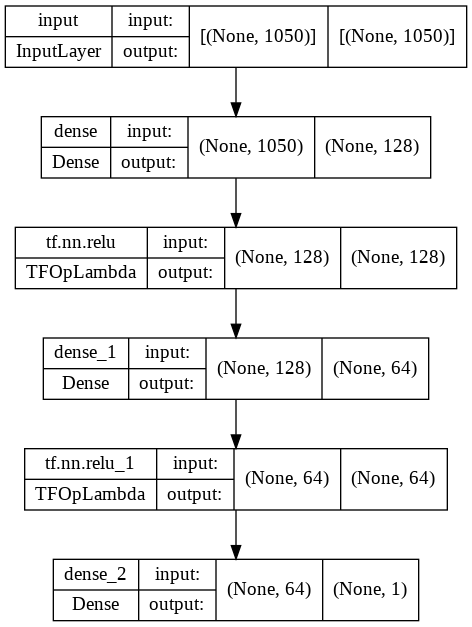

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

# Training

In [16]:
# utils
def seed_everything(seed : int):    
    """set seed for the reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(42)

def get_time_series_cross_val_splits(data, cv=3, embargo=4, era_col='era'):
    """Numerai data splitter for cross validation
    use embargo = 12 when use target_XXX_60 to avoid potential leakage (target days / 5)
    
    https://github.com/numerai/example-scripts/blob/master/utils.py
    """
    all_train_eras = data[era_col].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [all_train_eras[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last eras, in case the number of eras wasn't divisible by cv
    test_splits[-1] = np.append(test_splits[-1], all_train_eras[-1])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_eras if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let's embargo everything by 60/5 == 12 eras.
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo and abs(int(e) - test_split_min) > embargo]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

def plot_history(history, fold_id: int, seed: int):
    """Plot learning history
    """
    x = np.arange(1, len(history.history['loss']))
    plt.plot(x, history.history['loss'][1:], label=f'tr (fold={fold_id})')
    plt.plot(x, history.history['val_loss'][1:], label=f'val (fold={fold_id})')
    plt.title(f'Model loss (seed = {seed})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

def create_dataset(df: pd.DataFrame, features: list, target: str, batch_size: int=64, shuffle: bool=False, ):
    """Create tf dataset from pd.DataFrame
    """
    dataset = tf.data.Dataset.from_tensor_slices((df[features].values, df[target].values))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

  0%|          | 0/5 [00:00<?, ?it/s]


Current seed = 42

doing split 1 out of 4
Epoch 1/30
461/468 [============================>.] - ETA: 0s - loss: 30.7794
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed42.hdf5
468/468 [==============================] - 6s 8ms/step - loss: 30.3760 - val_loss: 0.0595 - lr: 0.0100
Epoch 2/30
466/468 [============================>.] - ETA: 0s - loss: 0.0555
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed42.hdf5
468/468 [==============================] - 3s 7ms/step - loss: 0.0555 - val_loss: 0.0544 - lr: 0.0100
Epoch 3/30
463/468 [============================>.] - ETA: 0s - loss: 0.0538
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed42.hdf5
468/468 [==============================] - 3s 7ms/step - loss: 0.0538 - val_loss: 0.0529 - lr: 0.0100
Epoch 4/30
467/468 [============================>.] - ETA: 0s - loss: 0.0795
Epoch 4: saving model to /content/drive/M

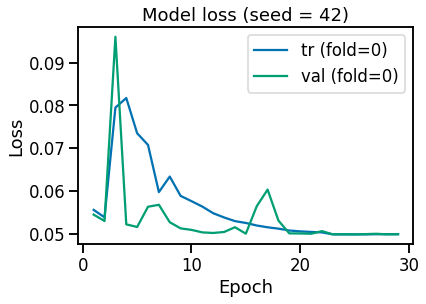

doing split 2 out of 4
Epoch 1/30
424/424 [==============================] - ETA: 0s - loss: 1.3754
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed42.hdf5
424/424 [==============================] - 5s 10ms/step - loss: 1.3754 - val_loss: 0.0615 - lr: 0.0020
Epoch 2/30
414/424 [============================>.] - ETA: 0s - loss: 0.0570
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed42.hdf5
424/424 [==============================] - 3s 8ms/step - loss: 0.0570 - val_loss: 0.0570 - lr: 0.0020
Epoch 3/30
421/424 [============================>.] - ETA: 0s - loss: 0.0546
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed42.hdf5
424/424 [==============================] - 3s 8ms/step - loss: 0.0546 - val_loss: 0.0562 - lr: 0.0020
Epoch 4/30
421/424 [============================>.] - ETA: 0s - loss: 0.0535
Epoch 4: saving model to /content/drive/MyDrive/ColabNotebooks

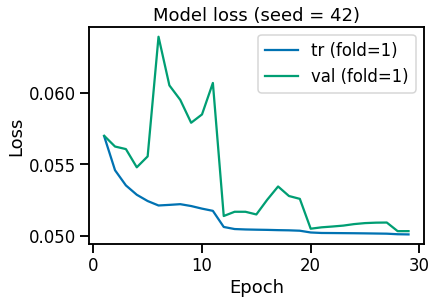

doing split 3 out of 4
Epoch 1/30
425/429 [============================>.] - ETA: 0s - loss: 0.3861
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed42.hdf5
429/429 [==============================] - 4s 9ms/step - loss: 0.3843 - val_loss: 0.1769 - lr: 1.6000e-05
Epoch 2/30
424/429 [============================>.] - ETA: 0s - loss: 0.1459
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed42.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.1456 - val_loss: 0.1243 - lr: 1.6000e-05
Epoch 3/30
424/429 [============================>.] - ETA: 0s - loss: 0.1118
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed42.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.1116 - val_loss: 0.1009 - lr: 1.6000e-05
Epoch 4/30
428/429 [============================>.] - ETA: 0s - loss: 0.0937
Epoch 4: saving model to /content/drive/MyDrive/Col

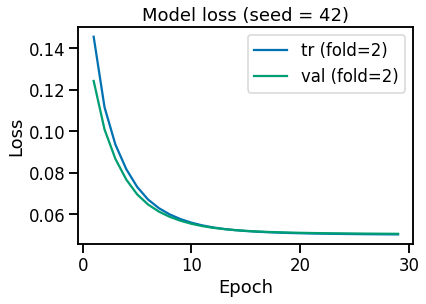

doing split 4 out of 4
Epoch 1/30
415/423 [============================>.] - ETA: 0s - loss: 0.4739
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed42.hdf5
423/423 [==============================] - 5s 10ms/step - loss: 0.4697 - val_loss: 0.2157 - lr: 1.6000e-05
Epoch 2/30
422/423 [============================>.] - ETA: 0s - loss: 0.1786
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed42.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.1786 - val_loss: 0.1485 - lr: 1.6000e-05
Epoch 3/30
415/423 [============================>.] - ETA: 0s - loss: 0.1341
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed42.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.1339 - val_loss: 0.1195 - lr: 1.6000e-05
Epoch 4/30
417/423 [============================>.] - ETA: 0s - loss: 0.1112
Epoch 4: saving model to /content/drive/MyDrive/Co

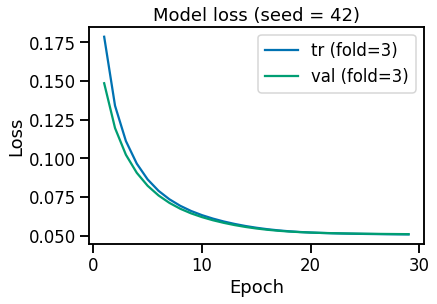


Current seed = 43

doing split 1 out of 4
Epoch 1/30
466/468 [============================>.] - ETA: 0s - loss: 0.4676
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed43.hdf5
468/468 [==============================] - 4s 9ms/step - loss: 0.4671 - val_loss: 0.2799 - lr: 1.6000e-05
Epoch 2/30
462/468 [============================>.] - ETA: 0s - loss: 0.2213
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed43.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.2209 - val_loss: 0.1939 - lr: 1.6000e-05
Epoch 3/30
461/468 [============================>.] - ETA: 0s - loss: 0.1624
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed43.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.1621 - val_loss: 0.1486 - lr: 1.6000e-05
Epoch 4/30
461/468 [============================>.] - ETA: 0s - loss: 0.1285
Epoch 4: saving model to /conte

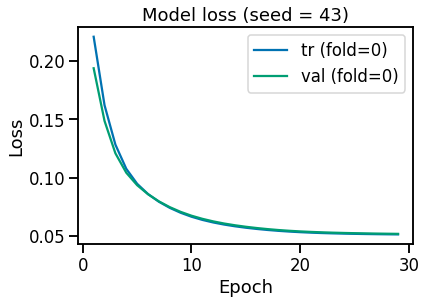

doing split 2 out of 4
Epoch 1/30
415/424 [============================>.] - ETA: 0s - loss: 0.5680
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed43.hdf5
424/424 [==============================] - 5s 10ms/step - loss: 0.5635 - val_loss: 0.3301 - lr: 1.6000e-05
Epoch 2/30
420/424 [============================>.] - ETA: 0s - loss: 0.2777
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed43.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 0.2774 - val_loss: 0.2332 - lr: 1.6000e-05
Epoch 3/30
423/424 [============================>.] - ETA: 0s - loss: 0.2068
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed43.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 0.2068 - val_loss: 0.1836 - lr: 1.6000e-05
Epoch 4/30
418/424 [============================>.] - ETA: 0s - loss: 0.1655
Epoch 4: saving model to /content/drive/MyDrive/Co

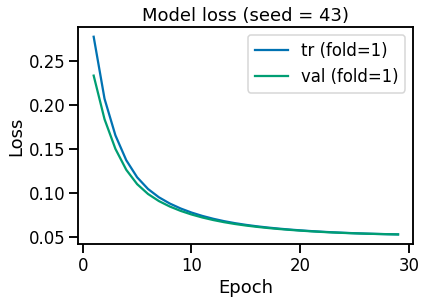

doing split 3 out of 4
Epoch 1/30
423/429 [============================>.] - ETA: 0s - loss: 0.6008
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed43.hdf5
429/429 [==============================] - 4s 9ms/step - loss: 0.5977 - val_loss: 0.3729 - lr: 1.6000e-05
Epoch 2/30
420/429 [============================>.] - ETA: 0s - loss: 0.3020
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed43.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.3011 - val_loss: 0.2624 - lr: 1.6000e-05
Epoch 3/30
425/429 [============================>.] - ETA: 0s - loss: 0.2276
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed43.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.2274 - val_loss: 0.2064 - lr: 1.6000e-05
Epoch 4/30
429/429 [==============================] - ETA: 0s - loss: 0.1830
Epoch 4: saving model to /content/drive/MyDrive/Col

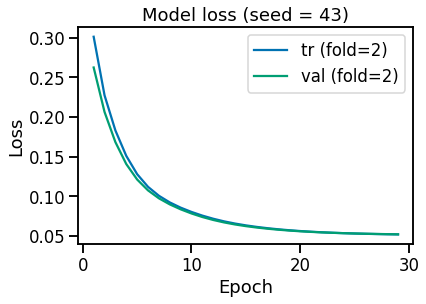

doing split 4 out of 4
Epoch 1/30
420/423 [============================>.] - ETA: 0s - loss: 0.6475
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed43.hdf5
423/423 [==============================] - 4s 10ms/step - loss: 0.6463 - val_loss: 0.3875 - lr: 1.6000e-05
Epoch 2/30
422/423 [============================>.] - ETA: 0s - loss: 0.3305
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed43.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.3305 - val_loss: 0.2778 - lr: 1.6000e-05
Epoch 3/30
419/423 [============================>.] - ETA: 0s - loss: 0.2515
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed43.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.2513 - val_loss: 0.2221 - lr: 1.6000e-05
Epoch 4/30
418/423 [============================>.] - ETA: 0s - loss: 0.2055
Epoch 4: saving model to /content/drive/MyDrive/Co

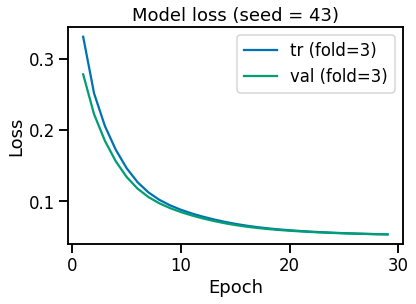


Current seed = 44

doing split 1 out of 4
Epoch 1/30
461/468 [============================>.] - ETA: 0s - loss: 0.5469
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed44.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.5437 - val_loss: 0.3194 - lr: 1.6000e-05
Epoch 2/30
464/468 [============================>.] - ETA: 0s - loss: 0.2549
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed44.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.2546 - val_loss: 0.2269 - lr: 1.6000e-05
Epoch 3/30
465/468 [============================>.] - ETA: 0s - loss: 0.1932
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed44.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.1931 - val_loss: 0.1826 - lr: 1.6000e-05
Epoch 4/30
462/468 [============================>.] - ETA: 0s - loss: 0.1595
Epoch 4: saving model to /conte

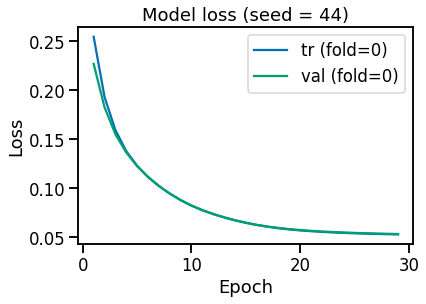

doing split 2 out of 4
Epoch 1/30
422/424 [============================>.] - ETA: 0s - loss: 0.6139
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed44.hdf5
424/424 [==============================] - 4s 8ms/step - loss: 0.6133 - val_loss: 0.3585 - lr: 1.6000e-05
Epoch 2/30
415/424 [============================>.] - ETA: 0s - loss: 0.2981
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed44.hdf5
424/424 [==============================] - 4s 8ms/step - loss: 0.2971 - val_loss: 0.2527 - lr: 1.6000e-05
Epoch 3/30
415/424 [============================>.] - ETA: 0s - loss: 0.2269
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed44.hdf5
424/424 [==============================] - 4s 8ms/step - loss: 0.2264 - val_loss: 0.2039 - lr: 1.6000e-05
Epoch 4/30
423/424 [============================>.] - ETA: 0s - loss: 0.1874
Epoch 4: saving model to /content/drive/MyDrive/Col

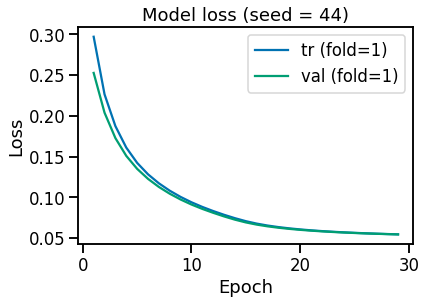

doing split 3 out of 4
Epoch 1/30
421/429 [============================>.] - ETA: 0s - loss: 0.6492
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed44.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.6444 - val_loss: 0.3819 - lr: 1.6000e-05
Epoch 2/30
422/429 [============================>.] - ETA: 0s - loss: 0.3163
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed44.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.3155 - val_loss: 0.2696 - lr: 1.6000e-05
Epoch 3/30
425/429 [============================>.] - ETA: 0s - loss: 0.2409
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed44.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.2407 - val_loss: 0.2180 - lr: 1.6000e-05
Epoch 4/30
423/429 [============================>.] - ETA: 0s - loss: 0.1998
Epoch 4: saving model to /content/drive/MyDrive/Col

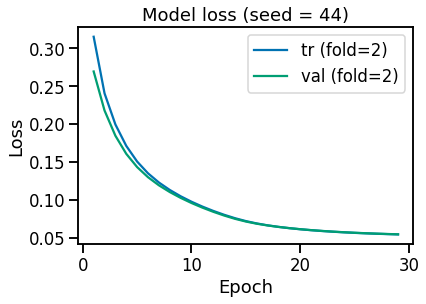

doing split 4 out of 4
Epoch 1/30
420/423 [============================>.] - ETA: 0s - loss: 0.6826
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed44.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.6814 - val_loss: 0.4160 - lr: 1.6000e-05
Epoch 2/30
422/423 [============================>.] - ETA: 0s - loss: 0.3415
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed44.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.3415 - val_loss: 0.2916 - lr: 1.6000e-05
Epoch 3/30
423/423 [==============================] - ETA: 0s - loss: 0.2601
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed44.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.2601 - val_loss: 0.2357 - lr: 1.6000e-05
Epoch 4/30
416/423 [============================>.] - ETA: 0s - loss: 0.2165
Epoch 4: saving model to /content/drive/MyDrive/Col

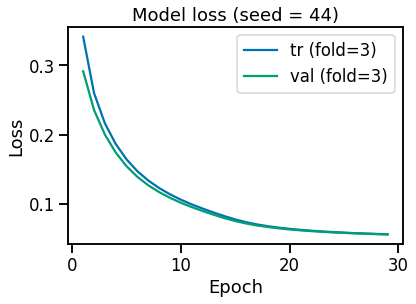


Current seed = 45

doing split 1 out of 4
Epoch 1/30
464/468 [============================>.] - ETA: 0s - loss: 0.8238
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed45.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.8222 - val_loss: 0.6011 - lr: 1.6000e-05
Epoch 2/30
464/468 [============================>.] - ETA: 0s - loss: 0.4979
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed45.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.4975 - val_loss: 0.4539 - lr: 1.6000e-05
Epoch 3/30
460/468 [============================>.] - ETA: 0s - loss: 0.3896
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed45.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.3890 - val_loss: 0.3671 - lr: 1.6000e-05
Epoch 4/30
464/468 [============================>.] - ETA: 0s - loss: 0.3210
Epoch 4: saving model to /conte

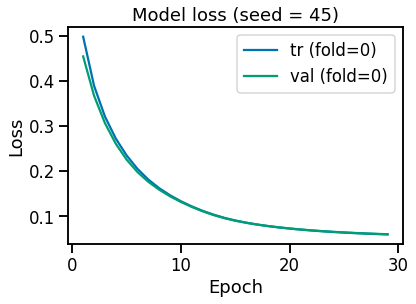

doing split 2 out of 4
Epoch 1/30
421/424 [============================>.] - ETA: 0s - loss: 0.8825
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed45.hdf5
424/424 [==============================] - 4s 8ms/step - loss: 0.8813 - val_loss: 0.6220 - lr: 1.6000e-05
Epoch 2/30
419/424 [============================>.] - ETA: 0s - loss: 0.5460
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed45.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 0.5454 - val_loss: 0.4826 - lr: 1.6000e-05
Epoch 3/30
422/424 [============================>.] - ETA: 0s - loss: 0.4367
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed45.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 0.4366 - val_loss: 0.3961 - lr: 1.6000e-05
Epoch 4/30
422/424 [============================>.] - ETA: 0s - loss: 0.3656
Epoch 4: saving model to /content/drive/MyDrive/Col

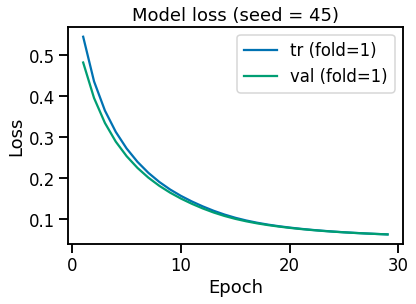

doing split 3 out of 4
Epoch 1/30
425/429 [============================>.] - ETA: 0s - loss: 0.9044
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed45.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.9022 - val_loss: 0.6308 - lr: 1.6000e-05
Epoch 2/30
426/429 [============================>.] - ETA: 0s - loss: 0.5638
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed45.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.5634 - val_loss: 0.4904 - lr: 1.6000e-05
Epoch 3/30
422/429 [============================>.] - ETA: 0s - loss: 0.4511
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed45.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 0.4504 - val_loss: 0.4062 - lr: 1.6000e-05
Epoch 4/30
426/429 [============================>.] - ETA: 0s - loss: 0.3764
Epoch 4: saving model to /content/drive/MyDrive/Col

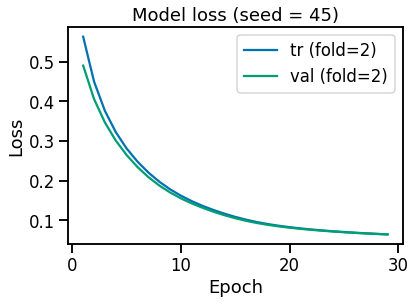

doing split 4 out of 4
Epoch 1/30
422/423 [============================>.] - ETA: 0s - loss: 0.9226
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed45.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.9226 - val_loss: 0.6689 - lr: 1.6000e-05
Epoch 2/30
422/423 [============================>.] - ETA: 0s - loss: 0.5850
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed45.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.5850 - val_loss: 0.5204 - lr: 1.6000e-05
Epoch 3/30
420/423 [============================>.] - ETA: 0s - loss: 0.4742
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed45.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 0.4740 - val_loss: 0.4306 - lr: 1.6000e-05
Epoch 4/30
417/423 [============================>.] - ETA: 0s - loss: 0.3994
Epoch 4: saving model to /content/drive/MyDrive/Col

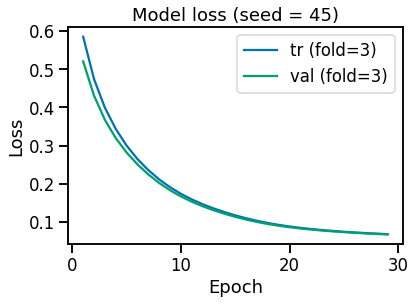


Current seed = 46

doing split 1 out of 4
Epoch 1/30
461/468 [============================>.] - ETA: 0s - loss: 2.2120
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed46.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 2.2001 - val_loss: 1.3288 - lr: 1.6000e-05
Epoch 2/30
460/468 [============================>.] - ETA: 0s - loss: 1.1079
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed46.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 1.1062 - val_loss: 1.0481 - lr: 1.6000e-05
Epoch 3/30
463/468 [============================>.] - ETA: 0s - loss: 0.8874
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold0_seed46.hdf5
468/468 [==============================] - 4s 8ms/step - loss: 0.8868 - val_loss: 0.8764 - lr: 1.6000e-05
Epoch 4/30
467/468 [============================>.] - ETA: 0s - loss: 0.7422
Epoch 4: saving model to /conte

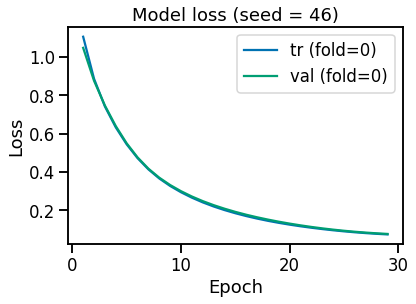

doing split 2 out of 4
Epoch 1/30
415/424 [============================>.] - ETA: 0s - loss: 2.3893
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed46.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 2.3703 - val_loss: 1.3883 - lr: 1.6000e-05
Epoch 2/30
419/424 [============================>.] - ETA: 0s - loss: 1.1947
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed46.hdf5
424/424 [==============================] - 4s 9ms/step - loss: 1.1937 - val_loss: 1.0916 - lr: 1.6000e-05
Epoch 3/30
415/424 [============================>.] - ETA: 0s - loss: 0.9812
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold1_seed46.hdf5
424/424 [==============================] - 4s 8ms/step - loss: 0.9797 - val_loss: 0.9084 - lr: 1.6000e-05
Epoch 4/30
424/424 [==============================] - ETA: 0s - loss: 0.8330
Epoch 4: saving model to /content/drive/MyDrive/Col

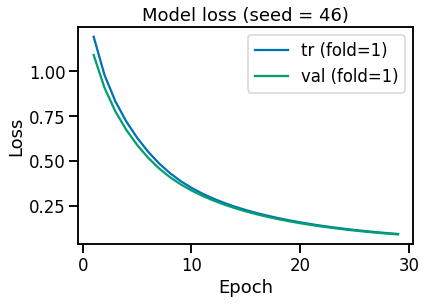

doing split 3 out of 4
Epoch 1/30
427/429 [============================>.] - ETA: 0s - loss: 2.4664
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed46.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 2.4627 - val_loss: 1.3260 - lr: 1.6000e-05
Epoch 2/30
426/429 [============================>.] - ETA: 0s - loss: 1.2334
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed46.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 1.2327 - val_loss: 1.0604 - lr: 1.6000e-05
Epoch 3/30
425/429 [============================>.] - ETA: 0s - loss: 1.0116
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold2_seed46.hdf5
429/429 [==============================] - 4s 8ms/step - loss: 1.0109 - val_loss: 0.8939 - lr: 1.6000e-05
Epoch 4/30
421/429 [============================>.] - ETA: 0s - loss: 0.8613
Epoch 4: saving model to /content/drive/MyDrive/Col

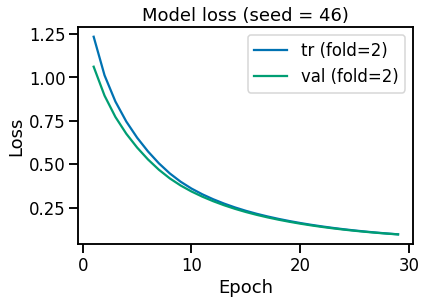

doing split 4 out of 4
Epoch 1/30
418/423 [============================>.] - ETA: 0s - loss: 2.5571
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed46.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 2.5455 - val_loss: 1.3952 - lr: 1.6000e-05
Epoch 2/30
414/423 [============================>.] - ETA: 0s - loss: 1.2711
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed46.hdf5
423/423 [==============================] - 4s 8ms/step - loss: 1.2675 - val_loss: 1.1179 - lr: 1.6000e-05
Epoch 3/30
415/423 [============================>.] - ETA: 0s - loss: 1.0479
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/NNNS/002_MLP/model_fold3_seed46.hdf5
423/423 [==============================] - 4s 9ms/step - loss: 1.0458 - val_loss: 0.9456 - lr: 1.6000e-05
Epoch 4/30
417/423 [============================>.] - ETA: 0s - loss: 0.8957
Epoch 4: saving model to /content/drive/MyDrive/Col

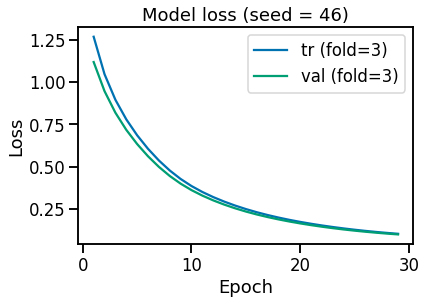

In [17]:
### EDIT THIS CELL, if necessary ###

# training config
NUM_SEEDS = 5
CV = 4
EMBARGO = 4

# callbacks?
def get_callbacks(fold_id: int, seed: int):
    """Get tf.keras callbacks
    - use earlystop?
    - which lr_scheduler?
    """
#     # early stopping
#     earlystop = tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', patience=10, verbose=2,
#         mode='min', restore_best_weights=True)
    
    # learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=7, verbose=2,
        mode='min')
    
    # save model weight
    checkpoint_path = f'{OUTPUT_DIR}/model_fold{fold_id}_seed{seed}.hdf5'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
         checkpoint_path, 
         save_weights_only=True,
         verbose=1)
    return [lr_scheduler, cp_callback]

def fit_with_cv(
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    features: list=features, 
    target: str=TARGET, 
    cv: int=2, 
    embargo: int=12, 
    seed: int=42,
    params: dict=params
    ):
    """Fit model with cross-validation
    """
    # train valid split
    train_test_zip = get_time_series_cross_val_splits(
        train_df, cv=cv, embargo=embargo, era_col='era'
    )
    
    # initialize pred column
    valid_df[f'pred_{target}_seed{seed}'] = 0
    
    # fit with CV
    for fold_id, train_test_split in enumerate(train_test_zip):
        # train test split
        print(f"doing split {fold_id+1} out of {cv}")
        train_split, val_split = train_test_split

        # get dataset
        train_dataset = create_dataset(
            train_df.query('era in @train_split'), features, target, batch_size=params['batch_size']
        )
        val_dataset = create_dataset(
            train_df.query('era in @val_split'), features, target, batch_size=params['batch_size']
        )
        
        # get callbacks
        callbacks = get_callbacks(fold_id, seed)

        # create model
        tf.keras.backend.clear_session()
        seed_everything(seed)
        model = OurNN()
        model = get_functional_model(model, params['input_dim'])
        model.compile(optimizer=optimizer, loss=loss_fn)
        
        # fit
        history = model.fit(
            train_dataset, 
            validation_data=val_dataset,
            epochs=params['epochs'],
            callbacks=callbacks,
            verbose=1
        )
        plot_history(history, fold_id, seed)
        
        # inference
        pred = model.predict(validation_data[features].values)        
        del history, model, train_dataset, val_dataset
        gc.collect()
        
        # assign
        valid_df[f'pred_{target}_seed{seed}'] +=  pred.ravel() / cv
        
    return valid_df
    
# fit with cross validation with different seeds
seeds = [42 + s for s in range(NUM_SEEDS)]
for seed in tqdm(seeds):
    print('')
    print(f'Current seed = {seed}')
    print('')
    
    # fit with cv
    validation_data = fit_with_cv(
        training_data, 
        validation_data, 
        features=features, 
        target=TARGET, 
        cv=CV, 
        embargo=EMBARGO, 
        seed=seed,
        params=params
    )
    
# seed average
pred_cols = [f for f in validation_data.columns if 'pred_' in f]
validation_data[f'pred_{TARGET}_seed_average'] = validation_data[pred_cols].values.mean(axis=1)

# Validation score

In [18]:
# https://github.com/numerai/example-scripts/blob/master/utils.py
def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)


def get_feature_neutral_mean(df, prediction_col, ERA_COL='era', TARGET_COL='target'):
    """Compute FNC (std, sharpe added)
    """
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [prediction_col],
                                          feature_cols)[prediction_col]
    scores = df.groupby(ERA_COL).apply(
        lambda x: (unif(x["neutral_sub"]).corr(x[TARGET_COL])))
    fnc = scores.mean()
    fnc_std = scores.std()
    fnc_sharpe = fnc / fnc_std
    return fnc, fnc_std, fnc_sharpe


def fast_score_by_date(df, columns, target, tb=None, era_col="era"):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        era_pred = np.float64(df_era[columns].values.T)
        era_target = np.float64(df_era[target].values.T)

        if tb is None:
            ccs = np.corrcoef(era_target, era_pred)[0, 1:]
        else:
            tbidx = np.argsort(era_pred, axis=1)
            tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
            ccs = [np.corrcoef(era_target[tmpidx], tmppred[tmpidx])[0, 1] for tmpidx, tmppred in zip(tbidx, era_pred)]
            ccs = np.array(ccs)

        computed.append(ccs)

    return pd.DataFrame(np.array(computed), columns=columns, index=df[era_col].unique())

def calculate_fnc(sub, targets, features):
    """    
    https://jp.docs.numer.ai/numerai-tnamento/feature-neutral-correlation
    Args:
        sub (pd.Series)
        targets (pd.Series)
        features (pd.DataFrame)
    """

    # Normalize submission
    sub = (sub.rank(method="first").values - 0.5) / len(sub)

    # Neutralize submission to features
    f = features.values
    sub -= f.dot(np.linalg.pinv(f).dot(sub))
    sub /= sub.std()

    sub = pd.Series(np.squeeze(sub)) # Convert np.ndarray to pd.Series

    # FNC: Spearman rank-order correlation of neutralized submission to target
    fnc = np.corrcoef(sub.rank(pct=True, method="first"), targets)[0, 1]

    return fnc

def validation_metrics_per_pred(pred_col, validation_data=validation_data, example_col='example_pred', fast_mode=False, ERA_COL='era', TARGET_COL='target'):
    validation_stats = pd.DataFrame()
    feature_cols = [c for c in validation_data if c.startswith("feature_")]
    
    # Check the per-era correlations on the validation set (out of sample)
    validation_correlations = validation_data.groupby(ERA_COL).apply(
        lambda d: unif(d[pred_col]).corr(d[TARGET_COL]))

    mean = validation_correlations.mean()
    std = validation_correlations.std(ddof=0)
    sharpe = mean / std

    validation_stats.loc["mean", pred_col] = mean
    validation_stats.loc["std", pred_col] = std
    validation_stats.loc["sharpe", pred_col] = sharpe

    rolling_max = (validation_correlations + 1).cumprod().rolling(window=9000,  # arbitrarily large
                                                                  min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
    validation_stats.loc["max_drawdown", pred_col] = max_drawdown

    payout_scores = validation_correlations.clip(-0.25, 0.25)
    payout_daily_value = (payout_scores + 1).cumprod()

    apy = (
        (
            (payout_daily_value.dropna().iloc[-1])
            ** (1 / len(payout_scores))
        )
        ** 49  # 52 weeks of compounding minus 3 for stake compounding lag
        - 1
    ) * 100

    validation_stats.loc["apy", pred_col] = apy

    if not fast_mode:
        # Check the feature exposure of your validation predictions
        max_per_era = validation_data.groupby(ERA_COL).apply(
            lambda d: d[feature_cols].corrwith(d[pred_col]).abs().max())
        max_feature_exposure = max_per_era.mean()
        validation_stats.loc["max_feature_exposure", pred_col] = max_feature_exposure

        # Check feature neutral mean
        fnc, fnc_std, fnc_sharpe = get_feature_neutral_mean(validation_data, pred_col)
        validation_stats.loc["fnc", pred_col] = fnc
        validation_stats.loc["fnc_std", pred_col] = fnc_std
        validation_stats.loc["fnc_sharpe", pred_col] = fnc_sharpe

        # Check top and bottom 200 metrics (TB200)
        tb200_validation_correlations = fast_score_by_date(
            validation_data,
            [pred_col],
            TARGET_COL,
            tb=200,
            era_col=ERA_COL
        )

        # Check top and bottom 200 metrics (TB200)
        tb200_mean = tb200_validation_correlations.mean()[pred_col]
        tb200_std = tb200_validation_correlations.std(ddof=0)[pred_col]
        tb200_sharpe = mean / std

        validation_stats.loc["tb200_mean", pred_col] = tb200_mean
        validation_stats.loc["tb200_std", pred_col] = tb200_std
        validation_stats.loc["tb200_sharpe", pred_col] = tb200_sharpe

    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in validation_data.groupby(ERA_COL):
        series = neutralize_series(unif(x[pred_col]), (x[example_col]))
        mmc_scores.append(np.cov(series, x[TARGET_COL])[0, 1] / (0.29 ** 2))
        corr_scores.append(unif(x[pred_col]).corr(x[TARGET_COL]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)

    validation_stats.loc["mmc_mean", pred_col] = val_mmc_mean
    validation_stats.loc["corr_plus_mmc_sharpe", pred_col] = corr_plus_mmc_sharpe

    # Check correlation with example predictions
    per_era_corrs = validation_data.groupby(ERA_COL).apply(lambda d: unif(d[pred_col]).corr(unif(d[example_col])))
    corr_with_example_preds = per_era_corrs.mean()
    validation_stats.loc["corr_with_example_preds", pred_col] = corr_with_example_preds
    return validation_stats

def validation_metrics(pred_cols):
    """Multiprocessing added
    """
    with Pool(cpu_count()) as p:
        validation_stats = list(tqdm(p.imap(validation_metrics_per_pred, pred_cols), total=len(pred_cols)))
    validation_stats = pd.concat(validation_stats, axis=1)
    
    # .transpose so that stats are columns and the model_name is the row
    return validation_stats.transpose()

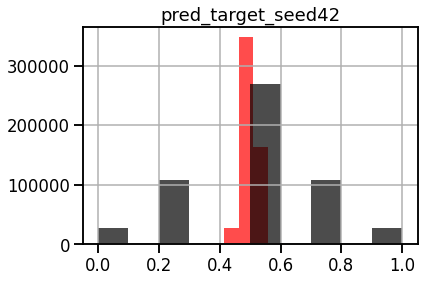

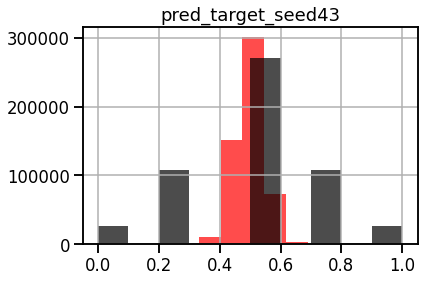

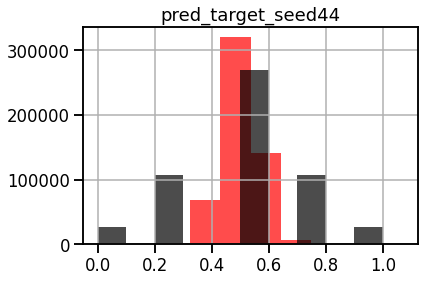

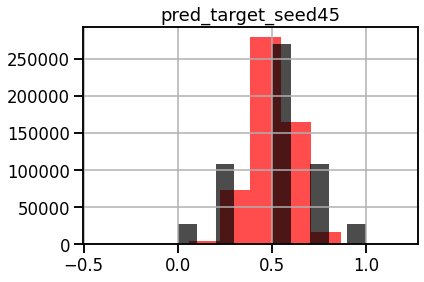

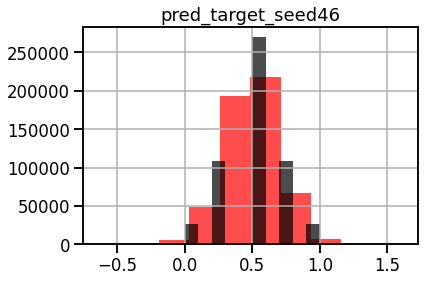

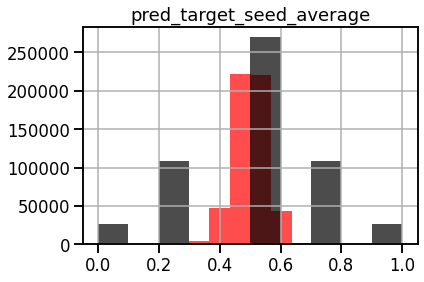

In [19]:
# plot hists of target and prediction
pred_cols = [f for f in validation_data.columns if 'pred_' in f]
for pred_col in pred_cols:
    validation_data[pred_col].hist(color='r', alpha=0.7, label='prediction')
    validation_data[TARGET].hist(color='k', alpha=0.7, label='target')
    plt.title(pred_col)
    plt.show()

In [20]:
%%time

# scoring
val_scores = validation_metrics(pred_cols)
val_scores.style.background_gradient(cmap='OrRd', axis=0)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 4.56 s, sys: 2.43 s, total: 6.99 s
Wall time: 13min 17s


ALL DONE!